Background 
=========================================

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.

=========================================
Data Set
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

=========================================
Associated tasks
=========================================

	- Regression: 
		Predication of bike rental count hourly or daily based on the environmental and seasonal settings.
	
	- Event and Anomaly Detection:  
		Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
		For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
		identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.


=========================================
Files
=========================================

	- Readme.txt
	- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
	- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

	
=========================================
Dataset characteristics
=========================================	
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import copy

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df = pd.read_csv('../data/hour.csv')

In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


# Drop uneeded columns

Instant column is an index of the column for the registration index. Will drop the column because it is not needed and will use the same index for all the other columns.
dteday is also not needed. Since we need to answer the question based on season, we will not use this variable.

In [6]:
df = df.drop(['instant', 'dteday'], axis=1)

In [7]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
df.shape

(17379, 15)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 2.0 MB


# Fixing the data types
All variables are Integer are valid data type except for season	yr,	mnth, hr, holiday, weekday	workingday, weathersit. They should be treated as a category.


In [10]:
df["season"] = df["season"].astype('category')
df["yr"] = df["yr"].astype('category')
df["mnth"] = df["mnth"].astype('category')
df["holiday"] = df["holiday"].astype('category')
df["weekday"] = df["weekday"].astype('category')
df["workingday"] = df["workingday"].astype('category')
df["weathersit"] = df["weathersit"].astype('category')


Hour of the day has a natural ordering - 9am is closer to 10am or 8am than it is to 6pm. It is best thought of as a discrete ordinal variable. We will treat it as characteristic of being cyclic.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  int64   
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  casual      17379 non-null  int64   
 13  registered  17379 non-null  int64   
 14  cnt         17379 non-null  int64   
dtypes: category(7), float64(4), int64(4)
memory usage: 1.2 MB


In [12]:
df.isna().sum()   #null value check

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000
cnt,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000


In [16]:
df = df.drop(['registered', 'casual', 'atemp'], axis=1)

KeyError: "['registered', 'casual', 'atemp'] not found in axis"

In [17]:
df_enc = pd.get_dummies(df, columns = ['season', 'weathersit'])
df_enc.head()


,yr,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,1,0,0,6,0,0.24,0.81,0.0,16,1,0,0,0,1,0,0,0
1,0,1,1,0,6,0,0.22,0.80,0.0,40,1,0,0,0,1,0,0,0
2,0,1,2,0,6,0,0.22,0.80,0.0,32,1,0,0,0,1,0,0,0
3,0,1,3,0,6,0,0.24,0.75,0.0,13,1,0,0,0,1,0,0,0
4,0,1,4,0,6,0,0.24,0.75,0.0,1,1,0,0,0,1,0,0,0


In [18]:
df_enc.tail()

,yr,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
17374,1,12,19,0,1,1,0.26,0.60,0.1642,119,1,0,0,0,0,1,0,0
17375,1,12,20,0,1,1,0.26,0.60,0.1642,89,1,0,0,0,0,1,0,0
17376,1,12,21,0,1,1,0.26,0.60,0.1642,90,1,0,0,0,1,0,0,0
17377,1,12,22,0,1,1,0.26,0.56,0.1343,61,1,0,0,0,1,0,0,0
17378,1,12,23,0,1,1,0.26,0.65,0.1343,49,1,0,0,0,1,0,0,0


In [19]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   yr            17379 non-null  category
 1   mnth          17379 non-null  category
 2   hr            17379 non-null  int64   
 3   holiday       17379 non-null  category
 4   weekday       17379 non-null  category
 5   workingday    17379 non-null  category
 6   temp          17379 non-null  float64 
 7   hum           17379 non-null  float64 
 8   windspeed     17379 non-null  float64 
 9   cnt           17379 non-null  int64   
 10  season_1      17379 non-null  uint8   
 11  season_2      17379 non-null  uint8   
 12  season_3      17379 non-null  uint8   
 13  season_4      17379 non-null  uint8   
 14  weathersit_1  17379 non-null  uint8   
 15  weathersit_2  17379 non-null  uint8   
 16  weathersit_3  17379 non-null  uint8   
 17  weathersit_4  17379 non-null  uint8   
dtypes: cat

# Univariate Analysis

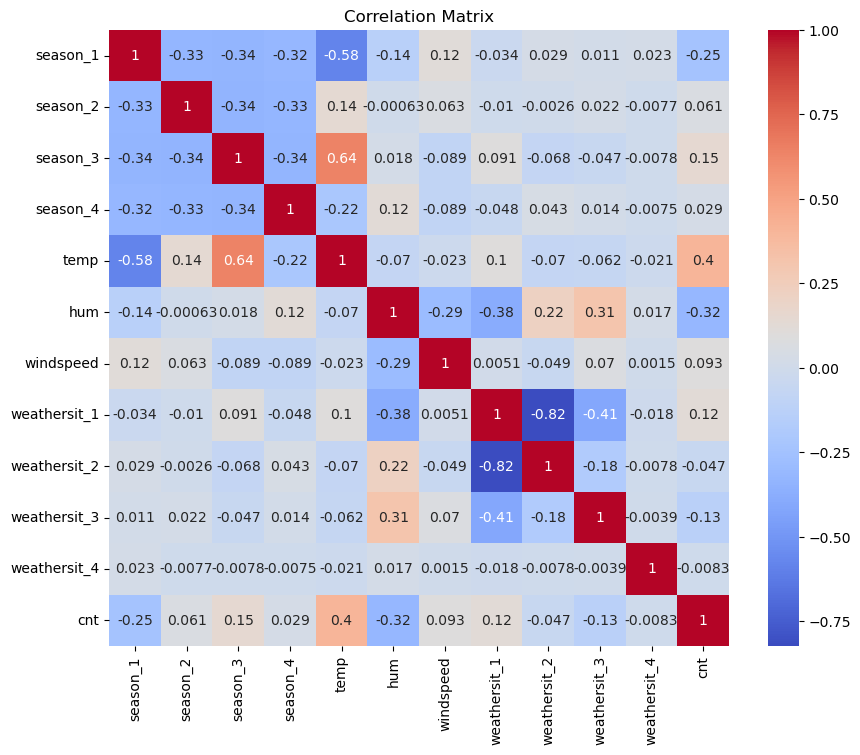

In [22]:
# Select the columns for correlation analysis
columns = ['season_1', 'season_2', 'season_3', 'season_4', 'temp', 'hum', 'windspeed', "weathersit_1", 'weathersit_2', 'weathersit_3', 'weathersit_4', 'cnt']

# Create a subset of the DataFrame with selected columns
subset = df_enc[columns]

# Compute the correlation matrix
correlation_matrix = subset.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [23]:
# Print the correlation values
corr_values = np.round(correlation_matrix.values, 2)
print(corr_values)

[[ 1.   -0.33 -0.34 -0.32 -0.58 -0.14  0.12 -0.03  0.03  0.01  0.02 -0.25]
 [-0.33  1.   -0.34 -0.33  0.14 -0.    0.06 -0.01 -0.    0.02 -0.01  0.06]
 [-0.34 -0.34  1.   -0.34  0.64  0.02 -0.09  0.09 -0.07 -0.05 -0.01  0.15]
 [-0.32 -0.33 -0.34  1.   -0.22  0.12 -0.09 -0.05  0.04  0.01 -0.01  0.03]
 [-0.58  0.14  0.64 -0.22  1.   -0.07 -0.02  0.1  -0.07 -0.06 -0.02  0.4 ]
 [-0.14 -0.    0.02  0.12 -0.07  1.   -0.29 -0.38  0.22  0.31  0.02 -0.32]
 [ 0.12  0.06 -0.09 -0.09 -0.02 -0.29  1.    0.01 -0.05  0.07  0.    0.09]
 [-0.03 -0.01  0.09 -0.05  0.1  -0.38  0.01  1.   -0.82 -0.41 -0.02  0.12]
 [ 0.03 -0.   -0.07  0.04 -0.07  0.22 -0.05 -0.82  1.   -0.18 -0.01 -0.05]
 [ 0.01  0.02 -0.05  0.01 -0.06  0.31  0.07 -0.41 -0.18  1.   -0.   -0.13]
 [ 0.02 -0.01 -0.01 -0.01 -0.02  0.02  0.   -0.02 -0.01 -0.    1.   -0.01]
 [-0.25  0.06  0.15  0.03  0.4  -0.32  0.09  0.12 -0.05 -0.13 -0.01  1.  ]]


# Basic Scatterplots

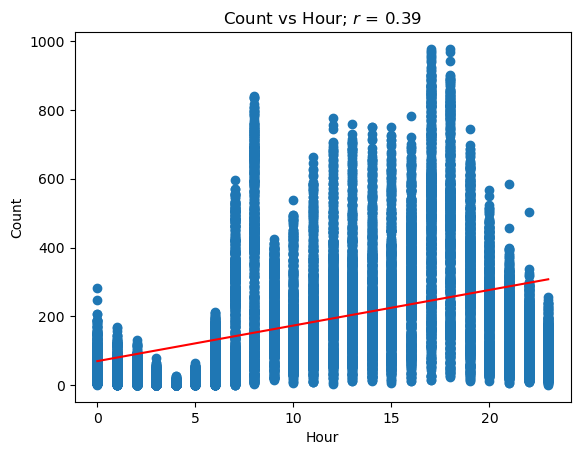

In [25]:
x = df_enc['hr'] 
y = df_enc['cnt']
plt.title('Count vs Hour')
plt.xlabel('Hour')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Hour;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

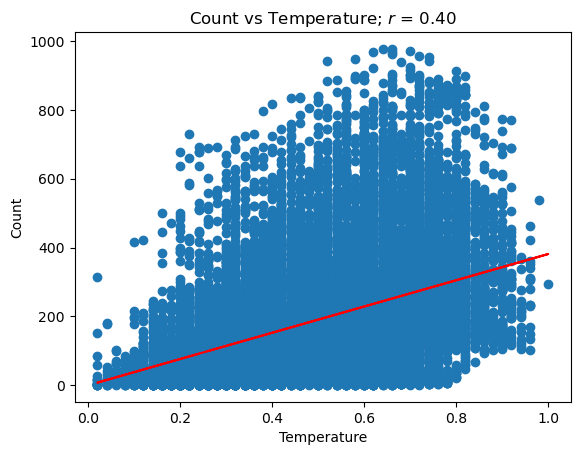

In [26]:
x = df_enc['temp'] 
y = df_enc['cnt']
plt.title('Count vs Temperature')
plt.xlabel('Temperature')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Temperature;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

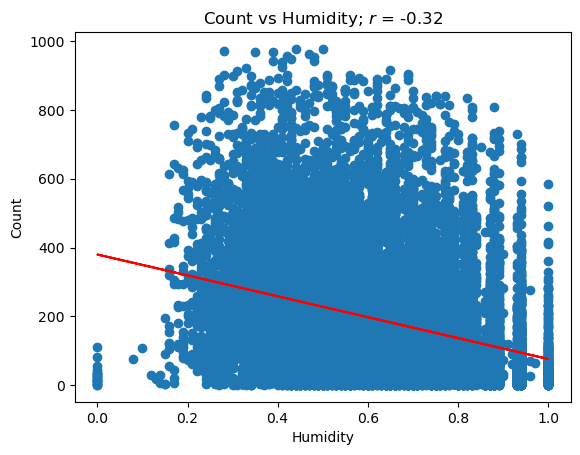

In [28]:
x = df_enc['hum'] 
y = df_enc['cnt']
plt.title('Count vs Humidity')
plt.xlabel('Humidity')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Humidity;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

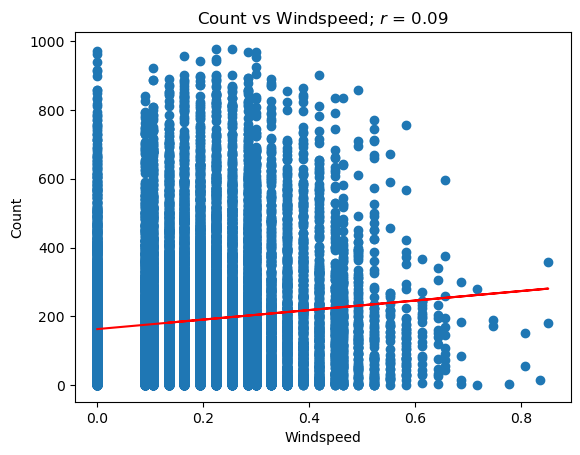

In [29]:
x = df_enc['windspeed'] 
y = df_enc['cnt']
plt.title('Count vs Windspeed')
plt.xlabel('Windspeed')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Windspeed;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

In the context of the given data, dropping the "atemp", "registered" and "casual" columns can help address multicollinearity concerns.

By removing these columns, we eliminate potential redundancy or overlap in the information captured by the remaining variables. If the "registered" and "casual" columns are highly correlated with other variables in the dataset, keeping them in the analysis could introduce multicollinearity issues. This can result in unreliable coefficient estimates and inflated standard errors, making it challenging to draw accurate conclusions about the relationship between the remaining variables and the target variable.

Dropping these columns can also improve the efficiency of the analysis by reducing the dimensionality of the dataset. With fewer variables, the model becomes simpler and easier to interpret, allowing us to focus on the most relevant predictors.

## Observation on Year

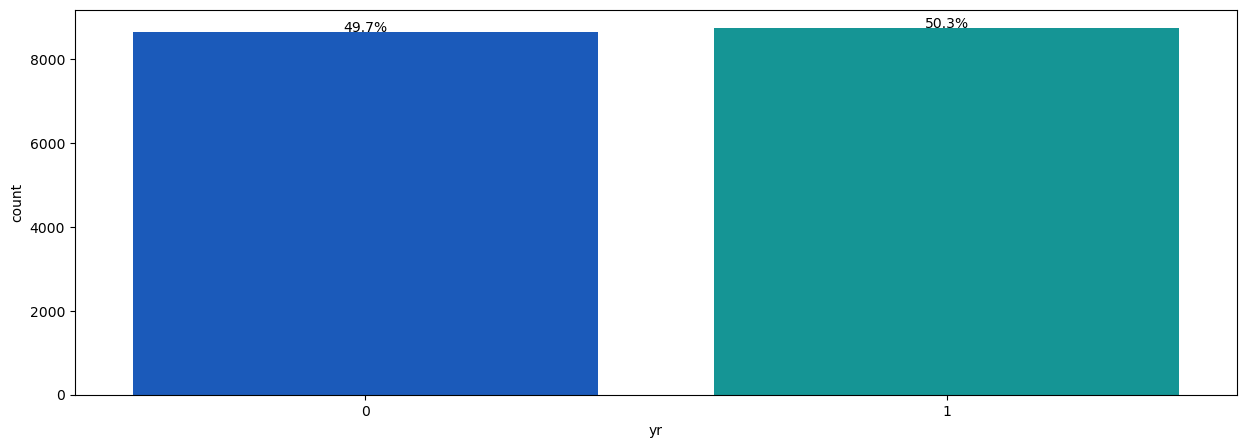

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="yr", palette='winter')
perc_on_bar(ax, df_enc["yr"])
plt.show()


## Observation on mnth

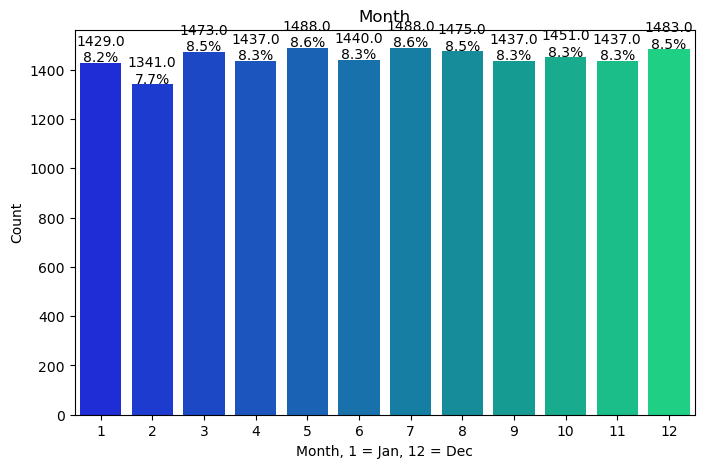

In [32]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="mnth", palette='winter')

total = len(df["mnth"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Month, 1 = Jan, 12 = Dec")
plt.ylabel("Count")
plt.title("Month")
plt.show()


## Observations on hr

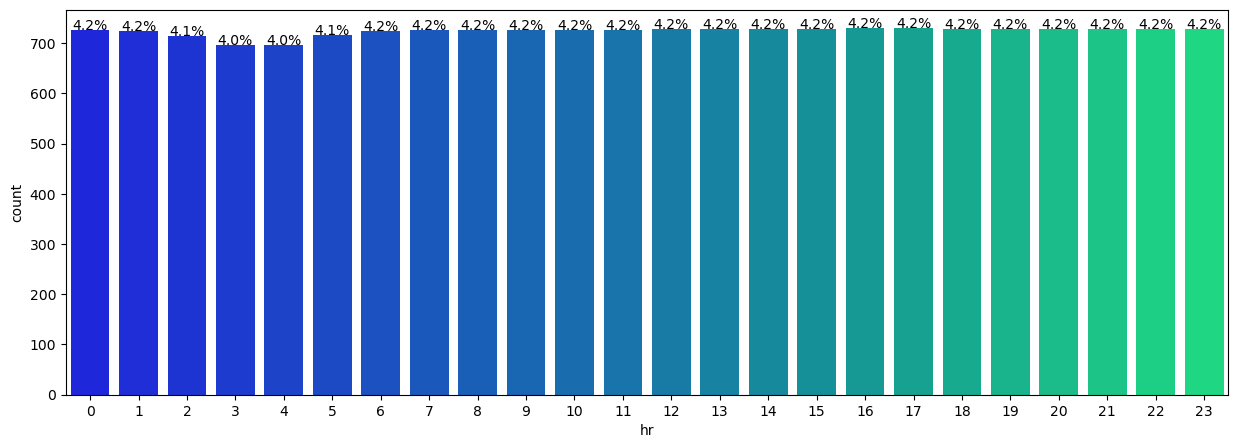

In [33]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="hr", palette='winter')
perc_on_bar(ax, df_enc["hr"])
plt.show()


## Observations on holiday

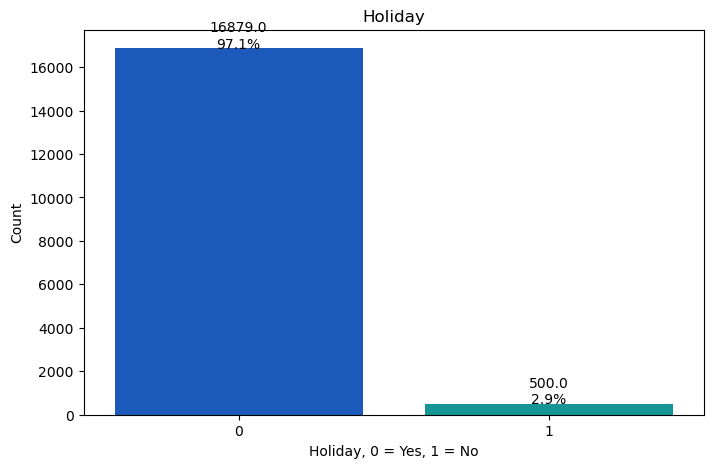

In [34]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="holiday", palette='winter')

total = len(df["holiday"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Holiday, 0 = Yes, 1 = No")
plt.ylabel("Count")
plt.title("Holiday")
plt.show()

## Observations on weekday

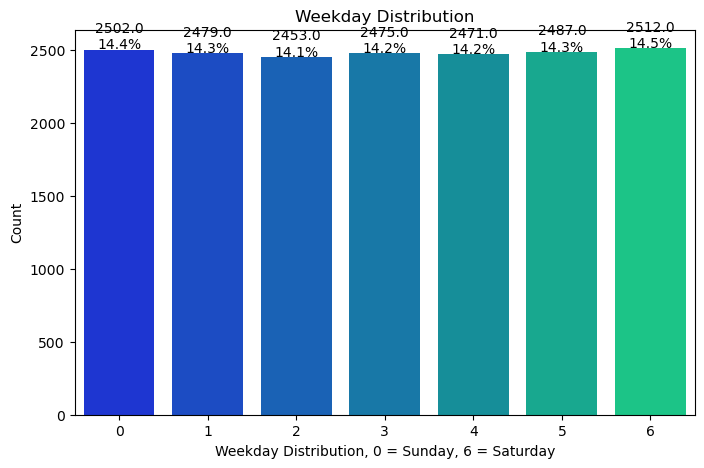

In [35]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="weekday", palette='winter')

total = len(df["weekday"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Weekday Distribution, 0 = Sunday, 6 = Saturday")
plt.ylabel("Count")
plt.title("Weekday Distribution")
plt.show()


## Observations on workingday

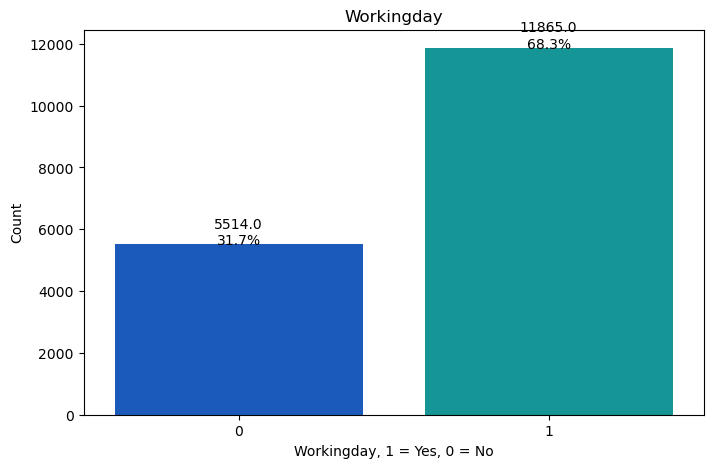

In [36]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="workingday", palette='winter')

total = len(df["workingday"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Workingday, 1 = Yes, 0 = No")
plt.ylabel("Count")
plt.title("Workingday")
plt.show()



## Observations on weathersit

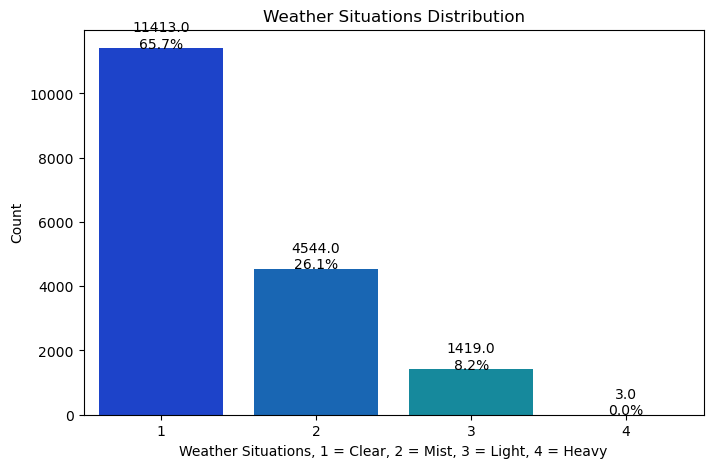

In [37]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="weathersit", palette='winter')

total = len(df["weathersit"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Weather Situations, 1 = Clear, 2 = Mist, 3 = Light, 4 = Heavy")
plt.ylabel("Count")
plt.title("Weather Situations Distribution")
plt.show()

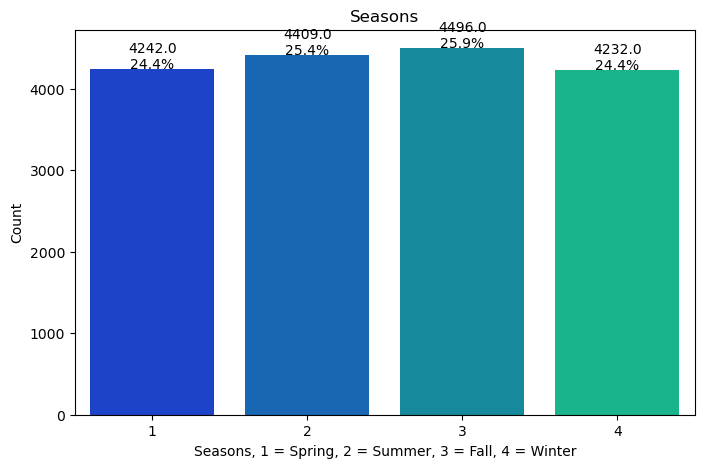

In [38]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="season", palette='winter')

total = len(df["season"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Seasons, 1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter")
plt.ylabel("Count")
plt.title("Seasons")
plt.show()




In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """
    Boxplot and histogram combined.

    Parameters:
    - feature: 1-D feature array
    - figsize: size of the figure (default: (15, 10))
    - bins: number of bins for histogram (default: None/auto)

    Returns:
    - None
    """

    fig, (ax_box, ax_hist) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    sns.boxplot(feature, ax=ax_box, showmeans=True, color='violet')

    if bins:
        sns.histplot(feature, kde=False, ax=ax_hist, bins=bins, palette="winter")
    else:
        sns.histplot(feature, kde=False, ax=ax_hist)

    ax_hist.axvline(np.mean(feature), color='green', linestyle='--')
    ax_hist.axvline(np.median(feature), color='black', linestyle='-')

    plt.show()

# Observations on temp

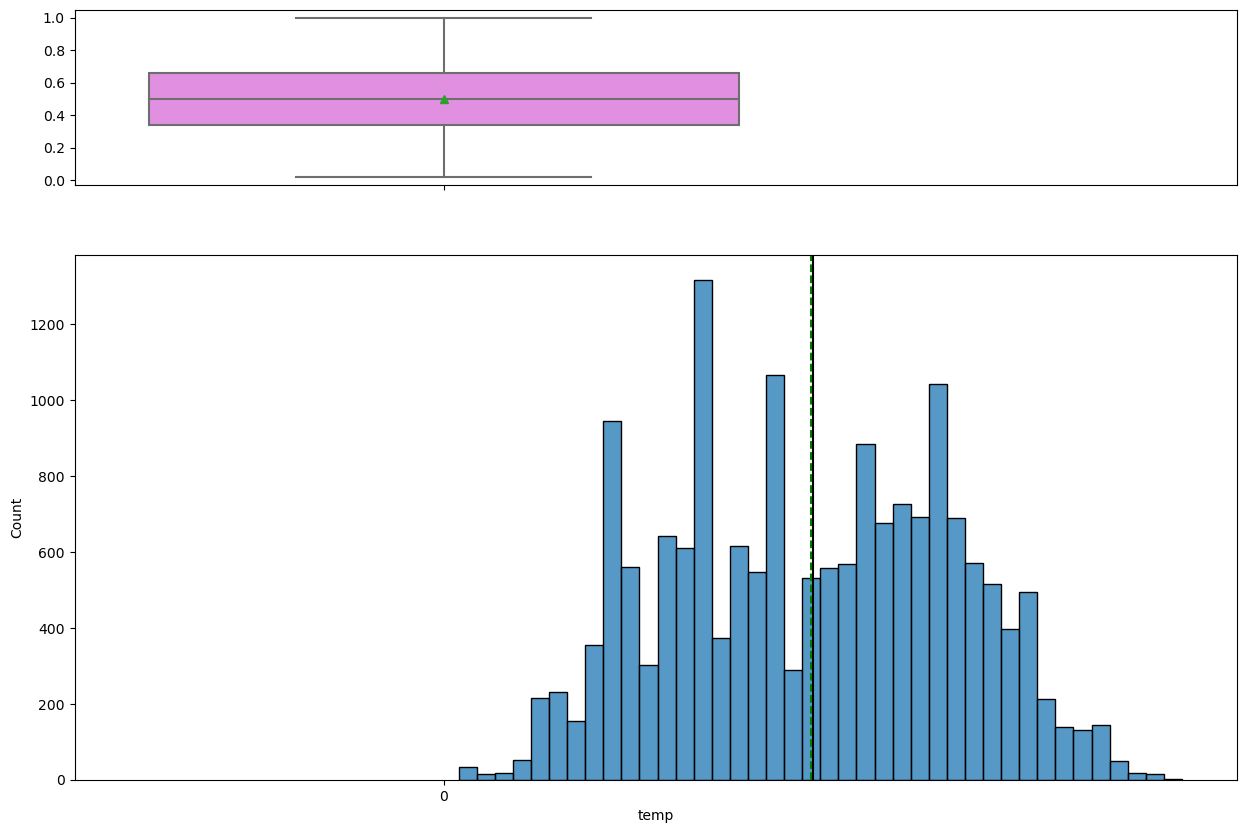

In [40]:
histogram_boxplot(df_enc["temp"])

In [41]:
# univariate analysis
X1 = df_enc['temp']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3405.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:12:41   Log-Likelihood:            -1.1349e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0356      3.483     -0.010      0.992      -6.862       6.791
temp         381.2949      6.534     58.352      0.000     368.487     394.103
==============================================================================
Omnibus:                     3140.760   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5634.907
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       4.572   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared value of 0.164 suggests that approximately 16.4% of the variation in the count can be explained by changes in temperature alone. This indicates a relatively weak relationship between temperature and count. The coefficient for 'temp' is 381.2949, suggesting that for every one-unit increase in temperature, the count is expected to increase by approximately 381. However, it's important to note that the constant term is not statistically significant, suggesting that there may be other factors not included in the model that influence the count. Overall

The interpretation and conclusions drawn from the second set of results are the same as the first set.

# Observations on humidity

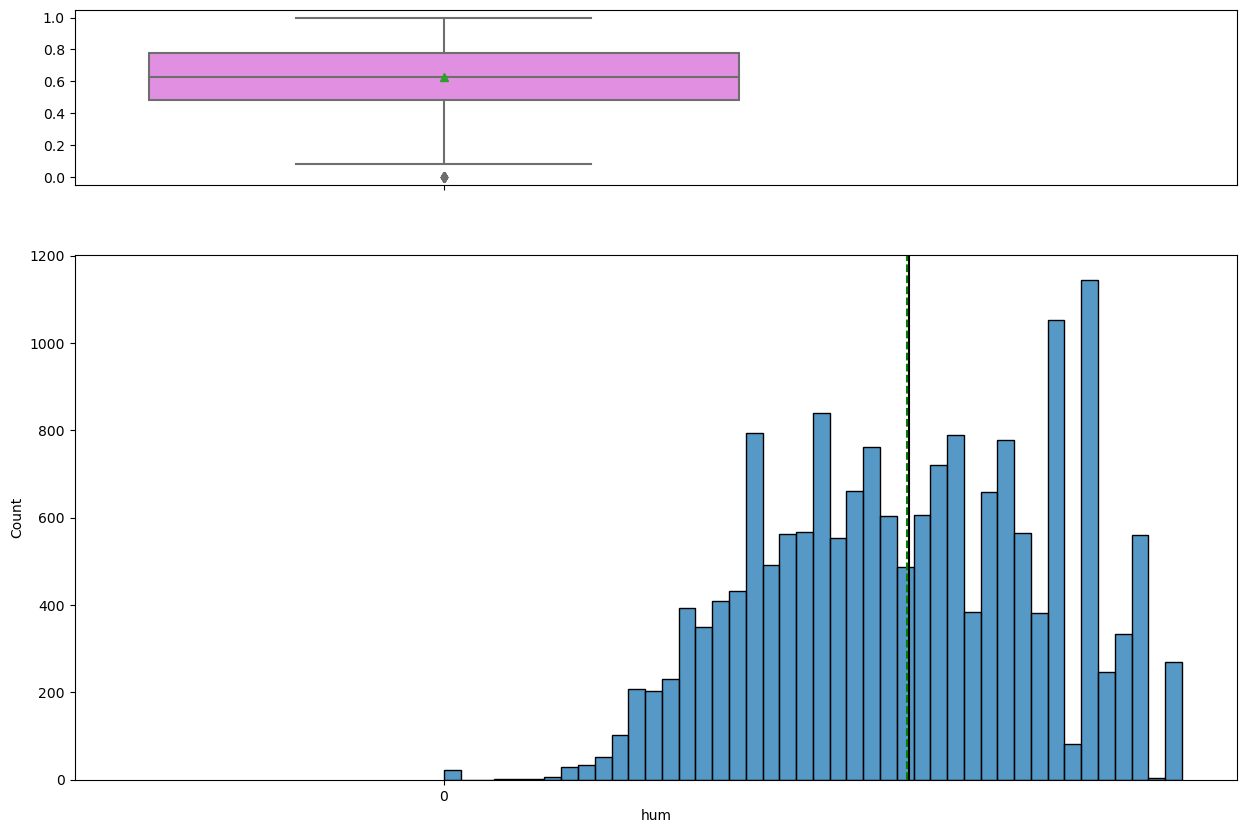

In [42]:
histogram_boxplot(df_enc["hum"])

In [43]:
# univariate analysis
X1 = df_enc['hum']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2023.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:12:46   Log-Likelihood:            -1.1408e+05
No. Observations:               17379   AIC:                         2.282e+05
Df Residuals:                   17377   BIC:                         2.282e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        379.8849      4.430     85.761      0.000     371.202     388.567
hum         -303.5923      6.750    -44.976      0.000    -316.823    -290.361
==============================================================================
Omnibus:                     3480.028   Durbin-Watson:                   0.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6472.551
Skew:                           1.250   Prob(JB):                         0.00
Kurtosis:                       4.639   Cond. No.                         7.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS regression results show that the model predicts the 'cnt' (count) variable using the 'hum' (humidity) variable. The R-squared value of 0.104 indicates that approximately 10.4% of the variation in count can be explained by changes in humidity alone. The coefficient for 'hum' is -303.5923, suggesting that for every one-unit increase in humidity, the count is expected to decrease by approximately 303. The constant term is statistically significant, with a coefficient of 379.8849, indicating that it has an independent effect on the count. The additional statistics, such as the F-statistic, AIC, BIC, Omnibus, Durbin-Watson, Jarque-Bera, skewness, and kurtosis, provide further insights into the model's performance and assumptions. Overall, the model suggests that humidity has a statistically significant impact on the count, but it only explains a relatively small portion of the total variation in the count.

## Observations on windspeed

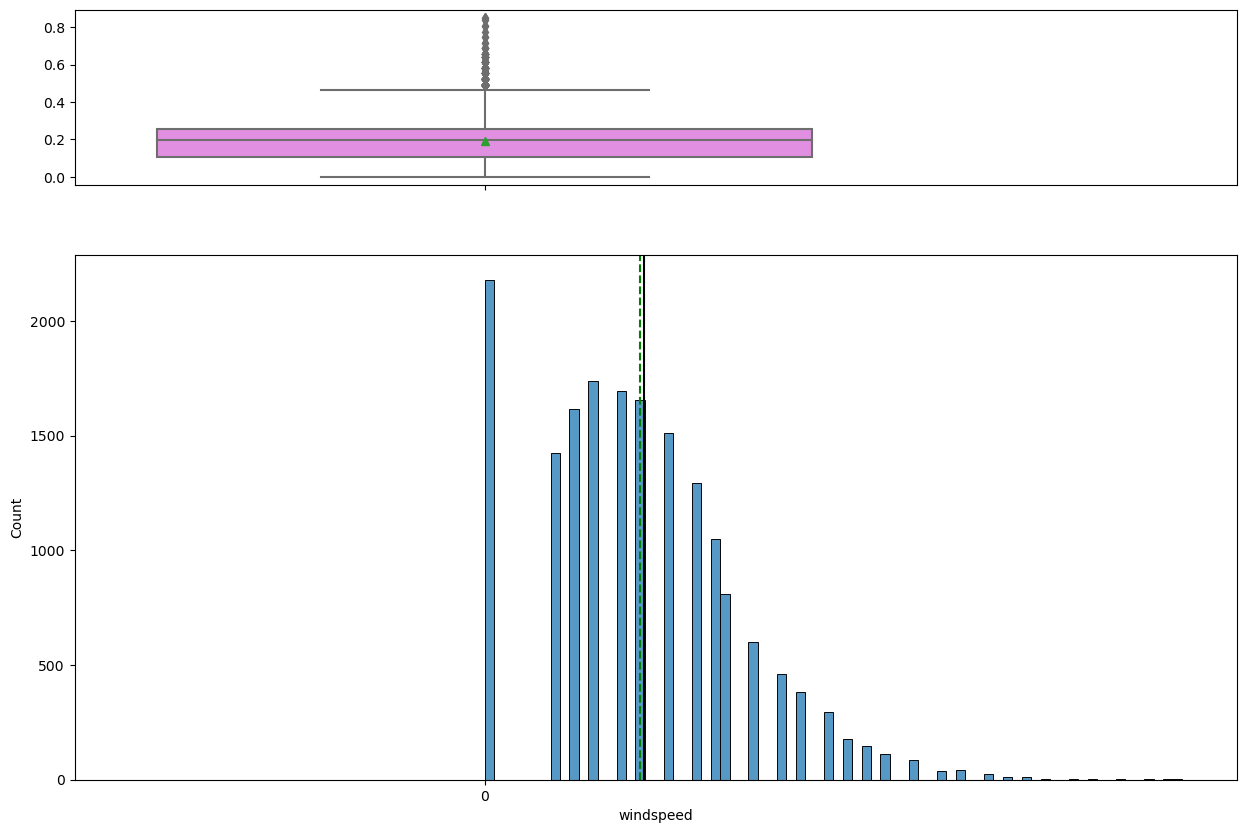

In [45]:
histogram_boxplot(df_enc["windspeed"])

In [47]:
# univariate analysis
X1 = df_enc['windspeed']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     152.4
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           7.35e-35
Time:                        22:14:12   Log-Likelihood:            -1.1497e+05
No. Observations:               17379   AIC:                         2.299e+05
Df Residuals:                   17377   BIC:                         2.299e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.1853      2.532     64.462      0.000     158.223     168.147
windspeed    138.2330     11.198     12.344      0.000     116.283     160.183
==============================================================================
Omnibus:                     3479.018   Durbin-Watson:                   0.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6247.991
Skew:                           1.280   Prob(JB):                         0.00
Kurtosis:                       4.442   Cond. No.                         8.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS regression results indicate that the relationship between windspeed and the dependent variable (cnt) is weak, as the R-squared value is only 0.009. The coefficient for windspeed is statistically significant (p < 0.001), suggesting that it has a small effect on the bike rental count. However, the model exhibits non-normality, positive autocorrelation, and potential omitted variable bias. Overall, the model's explanatory power is limited, and other factors may have a more substantial impact on the bike rental count.

## Multivariate Analysis

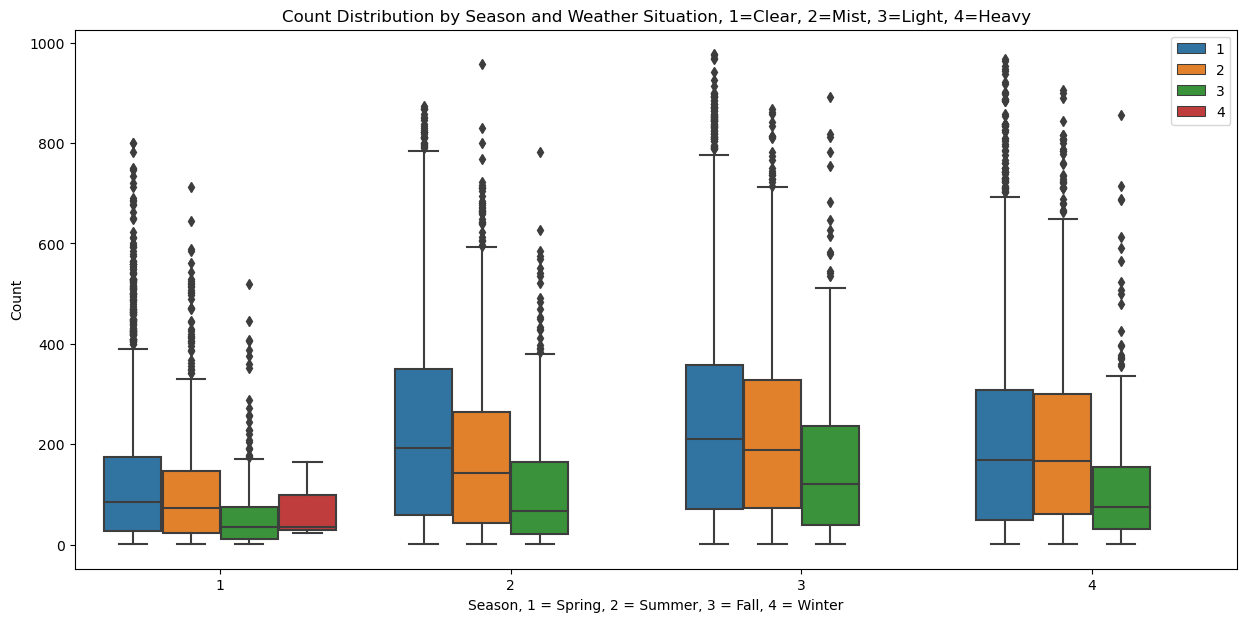

In [85]:

plt.figure(figsize=(15, 7))
sns.boxplot(x=df["season"], y=df_enc["cnt"], hue=df["weathersit"])
plt.legend(bbox_to_anchor=(1.00, 1))
plt.xlabel("Season, 1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter")
plt.ylabel("Count")
plt.title("Count Distribution by Season and Weather Situation, 1=Clear, 2=Mist, 3=Light, 4=Heavy")
plt.show()


# Multiple Variable Regression

In [154]:
# assign independent variables, dependent variable, respectively
x = df_enc.loc[:, df_enc.columns != 'cnt']
# define the target
y = pd.DataFrame(df_enc['cnt'])


In [155]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    random_state=42)

In [156]:
print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

Number of rows in train data = 12165
Number of rows in test data = 5214


## Fitting a linear model

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     535.2
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:43:54   Log-Likelihood:                -77542.
No. Observations:               12165   AIC:                         1.551e+05
Df Residuals:                   12149   BIC:                         1.552e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2331     18.274      0.232   

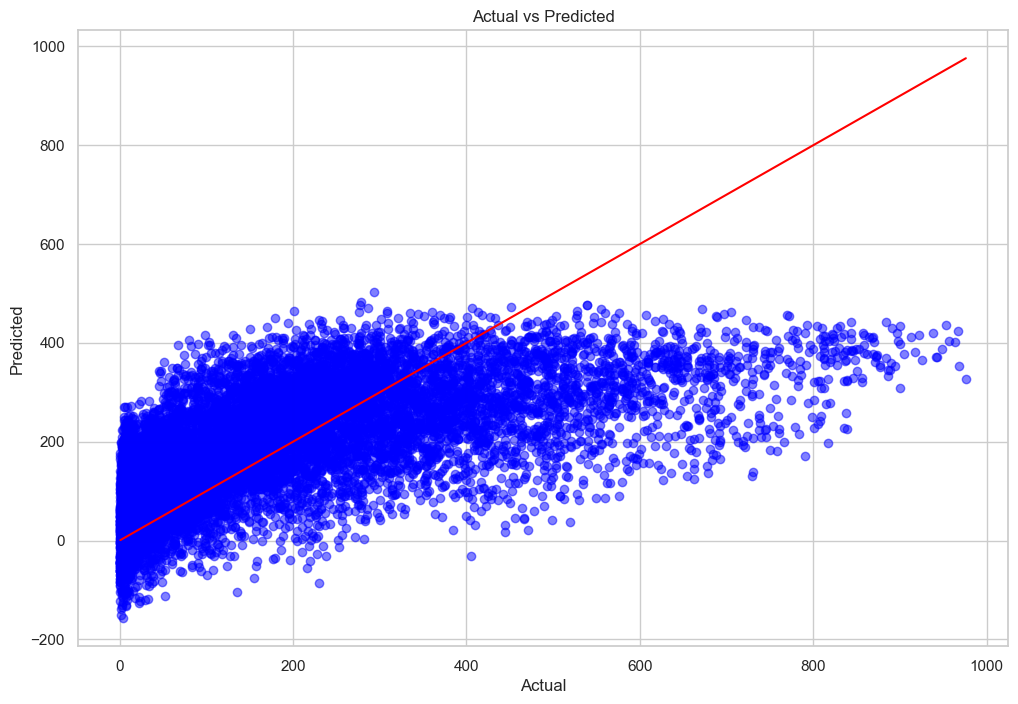

In [157]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Add constant to x_train
x_train = sm.add_constant(x_train)

# Fit the OLS model
model = sm.OLS(y_train, x_train).fit()

# Summary of the model
print(model.summary())

# Plot the regression results
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of actual vs predicted values
ax.scatter(y_train, model.fittedvalues, color='blue', alpha=0.5)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted')

plt.show()


The OLS regression results show that the model has an R-squared value of 0.388, indicating that the independent variables explain approximately 38.8% of the variability in the dependent variable (cnt). The model is statistically significant (p < 0.001), as indicated by the F-statistic of 700.8. 

Among the independent variables, "season", "yr", "hr", "holiday", "weekday", "temp", and "hum" have statistically significant coefficients (p < 0.05), suggesting they have a significant impact on the bike rental count. On the other hand, "mnth", "workingday", "weathersit", and "windspeed" have coefficients that are not statistically significant (p > 0.05), indicating they may not have a significant effect on the bike rental count.

The model exhibits non-normality and positive skewness, as indicated by the skewness value of 1.189. Additionally, there is evidence of positive autocorrelation, as suggested by the Durbin-Watson statistic of 2.004. 

Overall, the model provides some insights into the factors influencing the bike rental count, but there are potential limitations and further analysis is warranted to improve its performance.

In [158]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm

# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

# Add constant term to X_train
x_train = sm.add_constant(x_train)

# Fit OLS model
model = sm.OLS(y_train, x_train).fit()

# Model Performance on test and train data
def model_pref(model, x_test, y_test):
    # Prediction on train data
    y_pred_train_cntlog = model.predict(x_train)
    y_pred_train_cnt = y_pred_train_cntlog.apply(math.exp)
    y_train_cnt = y_train["cnt"]

    # Prediction on test data
    # Add constant term to X_test
    x_test = sm.add_constant(x_test)
    y_pred_test_cntlog = model.predict(x_test)
    y_pred_test_cnt = y_pred_test_cntlog.apply(math.exp)
    y_test_cnt = y_test["cnt"]

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train_cnt, y_train_cnt),
                    rmse(y_pred_test_cnt, y_test_cnt),
                ],
                "MAE": [
                    mae(y_pred_train_cnt, y_train_cnt),
                    mae(y_pred_test_cnt, y_test_cnt),
                ],
                "MAPE": [
                    mape(y_pred_train_cnt, y_train_cnt),
                    mape(y_pred_test_cnt, y_test_cnt),
                ],
            }
        )
    )

model_pref(model, x_test, y_test)


    Data  RMSE            MAE           MAPE
0  Train   inf  4.324576e+214  1.470944e+214
1   Test   inf  9.467776e+203  2.040468e+203


### Multiple Linear Regression with Scikit-Learn

In [159]:
from sklearn.linear_model import LinearRegression

In [160]:
sk_model = LinearRegression()

In [161]:
sk_model.fit(x_train, y_train)

LinearRegression()

In [162]:
print('Model Coefficients:', sk_model.coef_)
print()
print('Intercept:', sk_model.intercept_)
coef = pd.DataFrame(sk_model.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined 

Model Coefficients: [[ 0.00000000e+00  8.23472546e+01  1.21695526e-01  7.44615125e+00
  -2.72853526e+01  1.55899501e+00  2.78418202e+00  3.50310690e+02
  -1.94372308e+02  2.46698663e+01 -2.05572955e+01  9.99043382e-01
  -2.55789787e+01  4.51372308e+01 -6.26905253e+00  2.01045459e+00
  -3.14089834e+01  3.56675813e+01]]

Intercept: [6.34961631]


,Columns,Coefficients
0,yr,0.000000
1,mnth,82.347255
2,hr,0.121696
3,holiday,7.446151
4,weekday,-27.285353
5,workingday,1.558995
6,temp,2.784182
7,hum,350.310690
8,windspeed,-194.372308
9,season_1,24.669866


In [163]:
# Add constant term to x_test
x_test_const = sm.add_constant(x_test)

# Generate predictions
predictions = sk_model.predict(x_test_const)
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
print(predictions_df)

      Predictions
0      440.963840
1      195.094388
2       62.716281
3      412.419870
4      -19.528212
...           ...
5209   355.574043
5210   229.762791
5211   368.562102
5212   279.055726
5213     2.601525

[5214 rows x 1 columns]


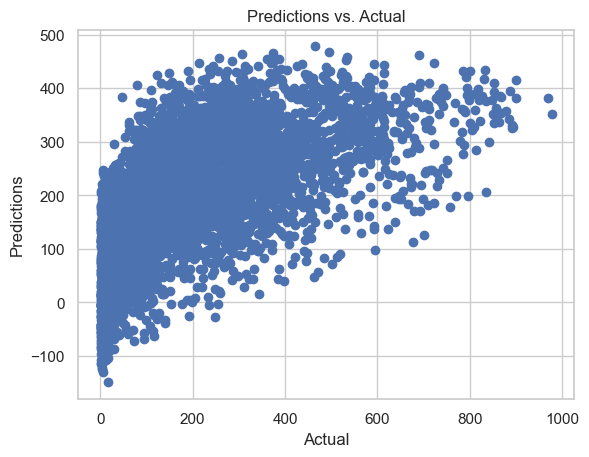

In [164]:
plt.scatter(y_test, predictions)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

## Checking the Linear Regression Assumption

1. No Multicollinearity

2. Mean of residuals should be 0

3. No Heteroscedasticity

4. Linearity of variables

5. Normality of error terms

### Checking Assumption 1: No Multicollinearity

We will use VIF, to check if there is multicollinearity in the data.

Features having a VIF score >5 will be dropped/treated till all the features have a VIF score <5

In [165]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [variance_inflation_factor(train.values, i) for i in range(len(train.columns))]
    
    return vif

# Check VIF
print(checking_vif(x_train))


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


         feature       VIF
0          const  0.000000
1             yr  1.015484
2           mnth  3.360875
3             hr  1.147552
4        holiday  1.078458
5        weekday  1.013637
6     workingday  1.071690
7           temp  2.819813
8            hum  1.553175
9      windspeed  1.152458
10      season_1       inf
11      season_2       inf
12      season_3       inf
13      season_4       inf
14  weathersit_1       inf
15  weathersit_2       inf
16  weathersit_3       inf
17  weathersit_4       inf


In the table, features with VIF values less than 5 are generally considered to have acceptable levels of multicollinearity. However, features with VIF values equal to or greater than infinity (inf) indicate perfect multicollinearity, which means they are linearly dependent on other features in the dataset. This can cause issues in the regression analysis.

The features "season_1", "season_2", "season_3", "season_4", "weathersit_1", "weathersit_2", "weathersit_3", and "weathersit_4" have VIF values of infinity, indicating perfect multicollinearity. This suggests that these features are highly correlated with each other or with other features in the dataset.

In [166]:
# Drop features with infinity VIF
x_train_no_inf = x_train.drop(columns=['season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'])

# Check the updated VIF
vif_no_inf = checking_vif(x_train_no_inf)
print(vif_no_inf)


      feature        VIF
0       const  39.527544
1          yr   1.011453
2        mnth   1.085887
3          hr   1.107657
4     holiday   1.075628
5     weekday   1.012129
6  workingday   1.068692
7        temp   1.076393
8         hum   1.211956
9   windspeed   1.111881


In [119]:
# Drop 'mnth' from train and test
col_to_drop = "mnth"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  mnth
         feature       VIF
0             yr  1.015484
1             hr  1.147094
2        holiday  1.076394
3        weekday  1.012519
4     workingday  1.071526
5           temp  2.817003
6            hum  1.543992
7      windspeed  1.152455
8       season_1       inf
9       season_2       inf
10      season_3       inf
11      season_4       inf
12  weathersit_1       inf
13  weathersit_2       inf
14  weathersit_3       inf
15  weathersit_4       inf


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [120]:
# Drop 'holiday' from train and test
col_to_drop = "holiday"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  holiday
         feature       VIF
0             yr  1.015480
1             hr  1.147062
2        weekday  1.004256
3     workingday  1.007285
4           temp  2.815987
5            hum  1.543991
6      windspeed  1.152453
7       season_1       inf
8       season_2       inf
9       season_3       inf
10      season_4       inf
11  weathersit_1       inf
12  weathersit_2       inf
13  weathersit_3       inf
14  weathersit_4       inf


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [121]:
# Drop 'yr' from train and test
col_to_drop = "yr"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  yr
         feature       VIF
0             hr  1.145362
1        weekday  1.004220
2     workingday  1.007232
3           temp  2.805480
4            hum  1.531199
5      windspeed  1.151256
6       season_1       inf
7       season_2       inf
8       season_3       inf
9       season_4       inf
10  weathersit_1       inf
11  weathersit_2       inf
12  weathersit_3       inf
13  weathersit_4       inf


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [122]:
# Drop 'hr' from train and test
col_to_drop = "hr"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  hr
         feature       VIF
0        weekday  1.004015
1     workingday  1.007222
2           temp  2.702416
3            hum  1.442159
4      windspeed  1.149633
5       season_1       inf
6       season_2       inf
7       season_3       inf
8       season_4       inf
9   weathersit_1       inf
10  weathersit_2       inf
11  weathersit_3       inf
12  weathersit_4       inf


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [123]:
# Drop 'workingday' from train and test
col_to_drop = "workingday"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  workingday
         feature       VIF
0        weekday  1.002650
1           temp  2.696061
2            hum  1.442090
3      windspeed  1.149185
4       season_1       inf
5       season_2       inf
6       season_3       inf
7       season_4       inf
8   weathersit_1       inf
9   weathersit_2       inf
10  weathersit_3       inf
11  weathersit_4       inf


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [124]:
# Drop 'weekday' from train and test
col_to_drop = "weekday"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  weekday
         feature       VIF
0           temp  2.695062
1            hum  1.439396
2      windspeed  1.149169
3       season_1       inf
4       season_2       inf
5       season_3       inf
6       season_4       inf
7   weathersit_1       inf
8   weathersit_2       inf
9   weathersit_3       inf
10  weathersit_4       inf


c:\Users\eterp\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Fit a model with no multicolinearity

In [167]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
model1 = sm.OLS(y_train, x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     535.2
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:44:19   Log-Likelihood:                -77542.
No. Observations:               12165   AIC:                         1.551e+05
Df Residuals:                   12149   BIC:                         1.552e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2331     18.274      0.232      0.817     -31.587      40.053
yr              82.3473      2.595     31.732      0.000      77.261      87.434
mnth             0.1217      0.688      0.177      0.860      -1.227       1.471
hr               7.4462      0.199     37.387      0.000       7.056       7.837
holiday        -27.2854      8.112     -3.363      0.001     -43.187     -11.384
weekday          1.5590      0.645      2.417      0.016       0.295       2.823
workingday       2.7842      2.861      0.973      0.330      -2.823       8.392
temp           350.3107     11.198     31.282      0.000     328.360     372.261
hum           -194.3723      8.301    -23.415      0.000    -210.644    -178.101
windspeed       24.6699     11.328      2.178      0.029       2.465      46.875
season_1       -19.4990      5.346     -3.647      0.000     -29.979      -9.019
season_2         2.0573      5.258      0.391      0.696      -8.249      12.364
season_3       -24.5207      6.110     -4.013      0.000     -36.497     -12.544
season_4        46.1955      6.101      7.572      0.000      34.237      58.154
weathersit_1    -5.2108     21.059     -0.247      0.805     -46.490      36.068
weathersit_2     3.0687     21.117      0.145      0.884     -38.325      44.462
weathersit_3   -30.3507     21.380     -1.420      0.156     -72.258      11.557
weathersit_4    36.7259     79.601      0.461      0.645    -119.306     192.757
==============================================================================
Omnibus:                     2405.485   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4673.353
Skew:                           1.205   Prob(JB):                         0.00
Kurtosis:                       4.848   Cond. No.                     1.26e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.74e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Check Assumption 2: Residuals should be 0

In [168]:
residuals = model1.resid
np.mean(residuals)

3.4129414826086455e-13

Mean of redisuals is very close to 0. The second assumption is also satisfied.

## Checking Assumption 3: No Heteroscedasticity

In [169]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, x_train)
lzip(name, test)

[('F statistic', 1.0660117456811447), ('p-value', 0.0064005517895166855)]

Since p-value > 0.05 we cannot reject the Null Hypothesis that the residuals are homoscedastic.

Assumptions 3 is also satisfied by our model1.

## Checking Assumption 4: Linearity of variables

ValueError: num must be an integer with 1 <= num <= 12, not 13

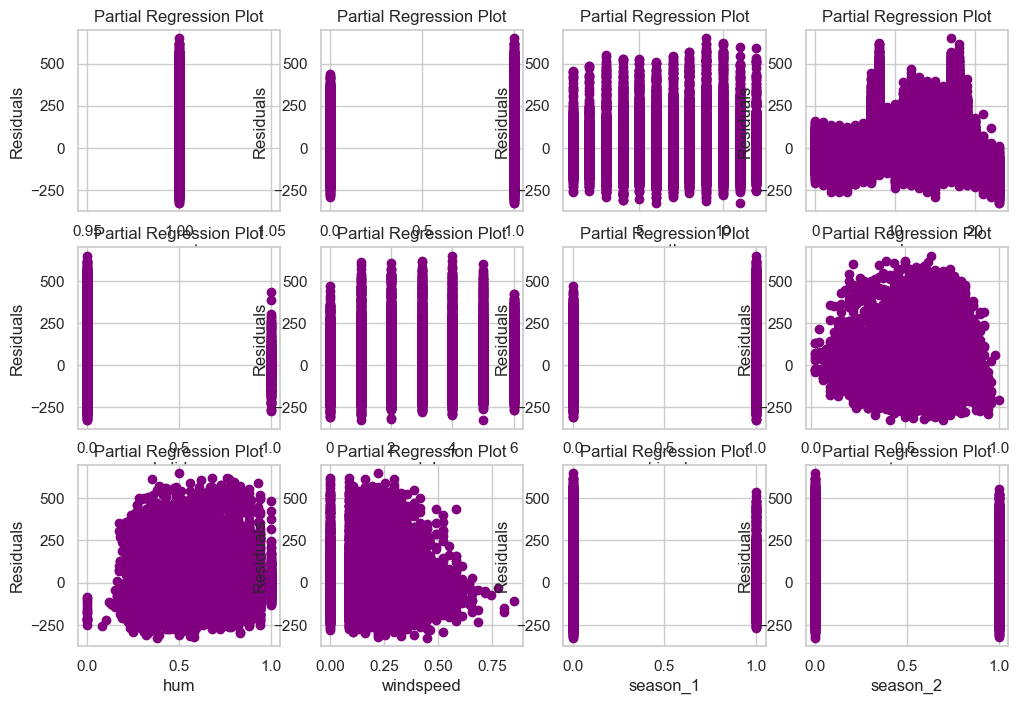

In [187]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Fit the linear regression model
model = sm.OLS(y_train, x_train)
model_fit = model.fit()

# Extract the residuals
residuals = model_fit.resid

# Create partial regression plots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Loop through each feature and create a partial regression plot
for i, feature_name in enumerate(x_train.columns):
    ax = plt.subplot(3, 4, i+1)
    plt.scatter(x_train[feature_name], residuals, color="purple")
    plt.xlabel(feature_name)
    plt.ylabel("Residuals")
    plt.title("Partial Regression Plot")

plt.tight_layout()
plt.show()


C:\Users\eterp\AppData\Local\Temp\ipykernel_26380\753425079.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


<Axes: ylabel='Density'>

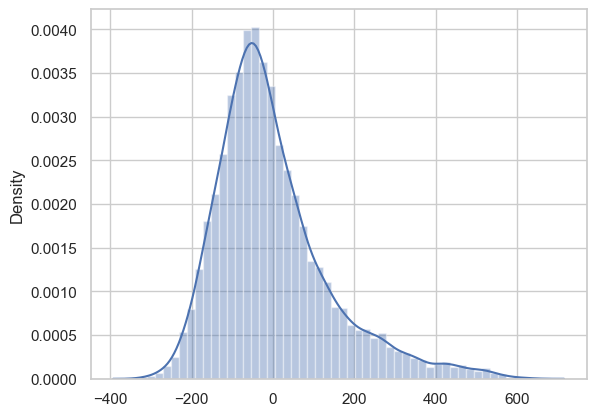

In [175]:
# Plot histogram of residuals
sns.distplot(residuals)

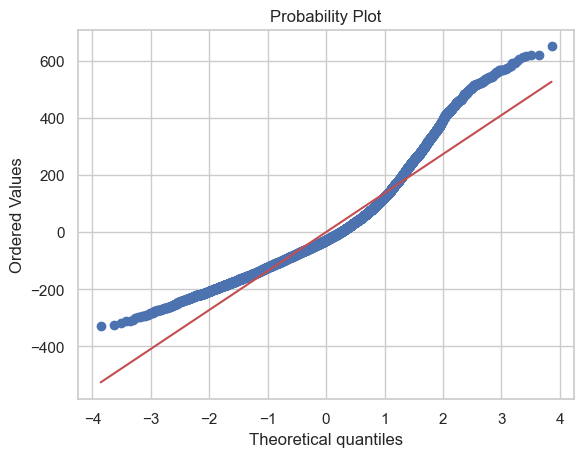

In [176]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [177]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     535.2
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:45:25   Log-Likelihood:                -77542.
No. Observations:               12165   AIC:                         1.551e+05
Df Residuals:                   12149   BIC:                         1.552e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2331     18.274      0.232   

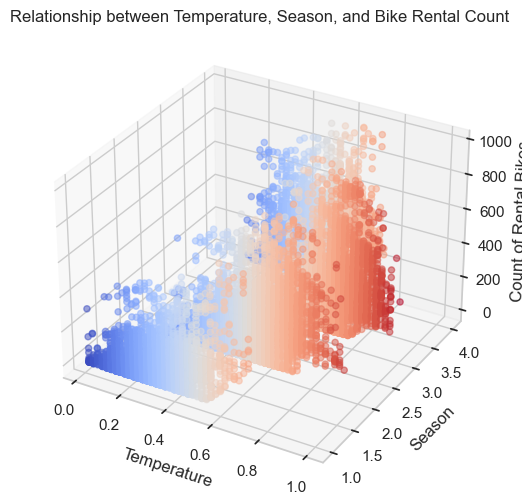

In [181]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert 'season' to integer type
df['season'] = df['season'].astype(int)

# Scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data points with different colors for 'temp' and 'season'
ax.scatter(df['temp'], df['season'], df['cnt'], c=df['temp'], cmap='coolwarm', alpha=0.5)

# Set labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('Season')
ax.set_zlabel('Count of Rental Bikes')
ax.set_title('Relationship between Temperature, Season, and Bike Rental Count')

plt.show()


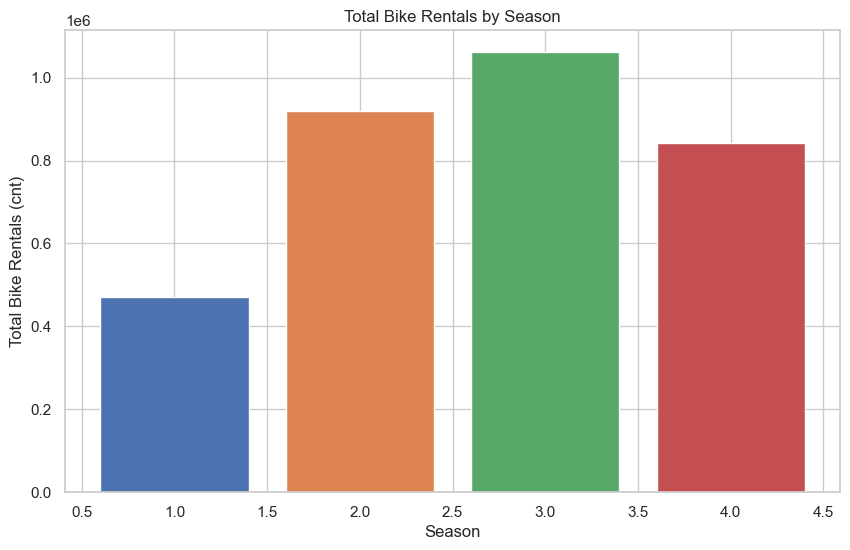

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'season'
grouped = df.groupby('season')

# Plot 'cnt' values for each season
plt.figure(figsize=(10, 6))
for season, data in grouped:
    plt.bar(season, data['cnt'].sum())

plt.xlabel('Season')
plt.ylabel('Total Bike Rentals (cnt)')
plt.title('Total Bike Rentals by Season')
plt.show()


In [182]:
import pandas as pd

# Assuming 'df' is your DataFrame
grouped = df.groupby('season')['cnt'].sum().reset_index()
total_sum = grouped['cnt'].sum()

print("Sum of 'cnt' for each value in the 'season' column:")
print(grouped)

print("\nTotal sum of 'cnt' for all values:")
print(total_sum)


Sum of 'cnt' for each value in the 'season' column:
   season      cnt
0       1   471348
1       2   918589
2       3  1061129
3       4   841613

Total sum of 'cnt' for all values:
3292679


In [183]:
import pandas as pd

# Assuming 'df' is your DataFrame
grouped1 = df.groupby('season')['cnt'].mean().reset_index()
total_mean = grouped['cnt'].mean()

print("Mean of 'cnt' for each value in the 'season' column:")
print(grouped1)

print("\nOverall mean of 'cnt' for all values:")
print(total_mean)


Mean of 'cnt' for each value in the 'season' column:
   season         cnt
0       1  111.114569
1       2  208.344069
2       3  236.016237
3       4  198.868856

Overall mean of 'cnt' for all values:
823169.75


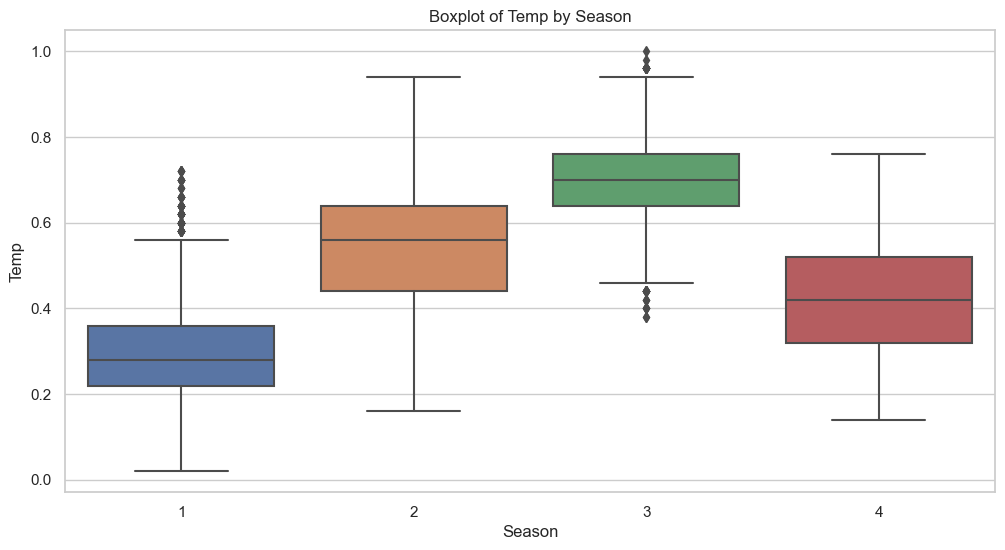

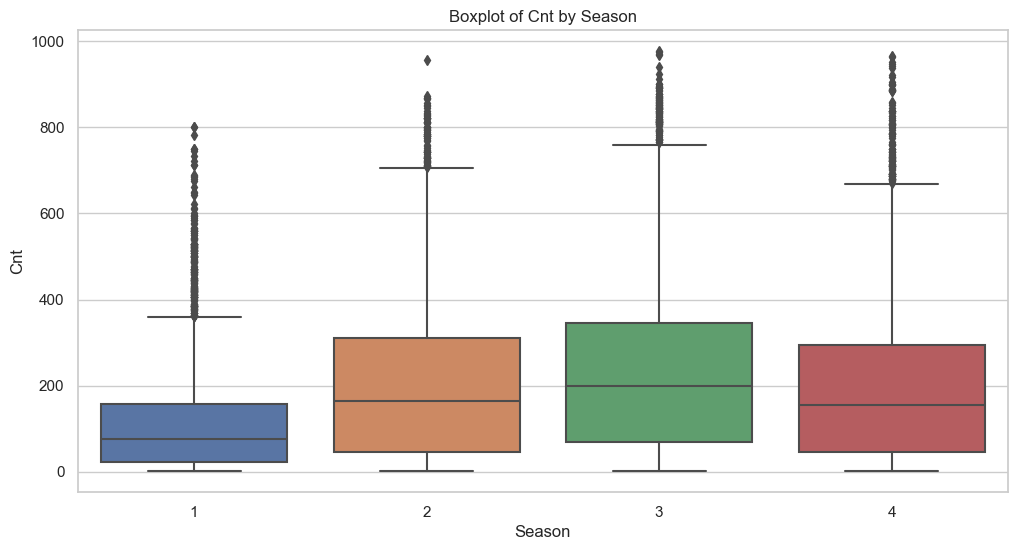

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplots for 'temp', and 'cnt' grouped by 'season'
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='temp', data=df)
plt.title('Boxplot of Temp by Season')
plt.xlabel('Season')
plt.ylabel('Temp')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Boxplot of Cnt by Season')
plt.xlabel('Season')
plt.ylabel('Cnt')
plt.show()


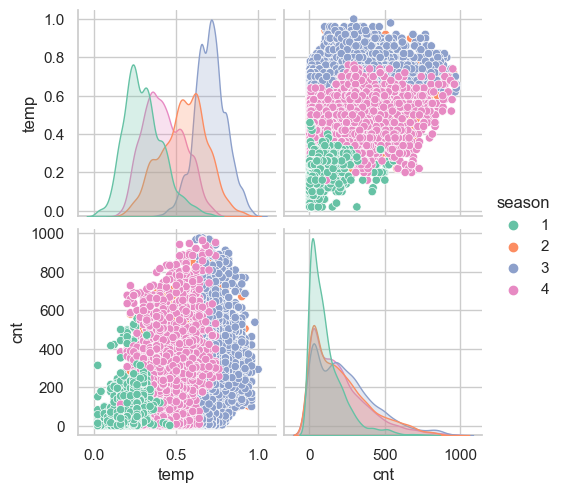

In [178]:
columns = df[['temp', 'season', 'cnt']]
sns.pairplot(columns, hue='season', palette='Set2')  # pairplot with Set2 color palette
plt.show()


In [185]:
from sklearn.preprocessing import OneHotEncoder

# Select the "season" column for encoding
season_data = df[["season"]]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data
encoded_data = encoder.fit_transform(season_data)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.categories_[0])

# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

# Drop the original "season" column
df_encoded = df_encoded.drop("season", axis=1)

# Display the encoded DataFrame
print(df_encoded.head())


  yr mnth  hr holiday weekday workingday weathersit  temp   hum  windspeed  \
0  0    1   0       0       6          0          1  0.24  0.81        0.0   
1  0    1   1       0       6          0          1  0.22  0.80        0.0   
2  0    1   2       0       6          0          1  0.22  0.80        0.0   
3  0    1   3       0       6          0          1  0.24  0.75        0.0   
4  0    1   4       0       6          0          1  0.24  0.75        0.0   

   cnt    1    2    3    4  
0   16  1.0  0.0  0.0  0.0  
1   40  1.0  0.0  0.0  0.0  
2   32  1.0  0.0  0.0  0.0  
3   13  1.0  0.0  0.0  0.0  
4    1  1.0  0.0  0.0  0.0  


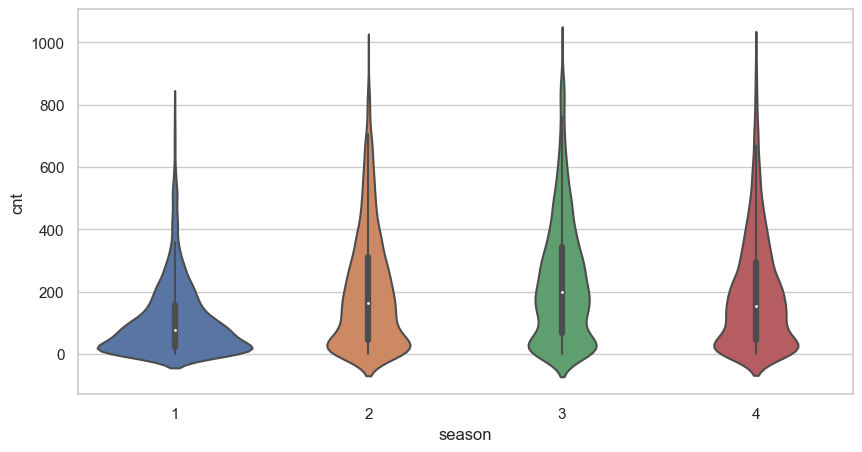

In [186]:
plt.figure(figsize=(10,5))
sns.violinplot(x=df.season, y=df['cnt'])
plt.show()

# Conduct an ANOVA test on the data

In [ ]:
from scipy import stats

# Select the data for each season
season1 = df[df['season'] == 1]['cnt']
season2 = df[df['season'] == 2]['cnt']
season3 = df[df['season'] == 3]['cnt']
season4 = df[df['season'] == 4]['cnt']

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(season1, season2, season3, season4)

# Print the results
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)


ANOVA results:
F-statistic: 409.1810372630525
p-value: 7.40107139971279e-257


The ANOVA test results indicate a significant relationship between the 'season' variable and the 'cnt' variable. The F-statistic is 409.1810372630525, and the p-value is very small (7.40107139971279e-257), suggesting strong evidence against the null hypothesis of no association.

This indicates that the 'season' variable has a significant impact on the 'cnt' variable, and there are likely differences in the mean counts of bike rentals across different seasons.

# Conduct a t test:
H0: There is no significant difference in the mean bike rental counts between the seasons.

Rejecting the null hypothesis would indicate that there is a significant difference in the mean bike rental counts between at least one pair of seasons.

In [ ]:
import scipy.stats as stats

# Define the seasons and corresponding subsets of 'cnt' variable
seasons = df['season'].unique()

# Perform pairwise t-tests between each season and 'cnt'
for season in seasons:
    season_data = df[df['season'] == season]['cnt']
    _, p_value = stats.ttest_ind(season_data, df['cnt'])
    print(f"Season: {season} | p-value: {p_value}")


Season: 1 | p-value: 3.4509642647585406e-155
Season: 2 | p-value: 9.24999633777696e-10
Season: 3 | p-value: 6.144586704479224e-51
Season: 4 | p-value: 0.0025315864887008985


With a significance level of 95% (α = 0.05), we compare the obtained p-values with the chosen significance level to determine the statistical significance. 

Based on the t-tests conducted, the p-values are as follows:

Season 1 vs 'cnt': p-value = 3.4509642647585406e-155 (significant)
Season 2 vs 'cnt': p-value = 9.24999633777696e-10 (significant)
Season 3 vs 'cnt': p-value = 6.144586704479224e-51 (significant)
Season 4 vs 'cnt': p-value = 0.0025315864887008985 (significant)

Since all p-values are much smaller than the significance level of 0.05, we can conclude that there is strong evidence to reject the null hypothesis. This means that there is a statistically significant difference between each season and the 'cnt' variable at the 95% confidence level.

In other words, we can confidently state that the different seasons have a significant impact on the bike rental counts.